In [58]:
from PIL import Image
from sklearn.cluster import KMeans

import csv
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd         
from torch import Tensor                  
import torch.nn as nn                     
import torch.nn.functional as F           
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from yellowbrick.cluster import KElbowVisualizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
images = []
for f in glob.iglob("images/?-?.png"):
    images.append(f)
images.sort()
print(images)

['images/1-1.png', 'images/1-2.png', 'images/1-3.png', 'images/1-4.png', 'images/2-1.png', 'images/2-2.png', 'images/2-3.png', 'images/2-4.png', 'images/3-1.png', 'images/3-2.png', 'images/3-3.png', 'images/3-4.png', 'images/4-1.png', 'images/4-2.png', 'images/4-3.png', 'images/4-4.png', 'images/5-1.png', 'images/5-2.png', 'images/5-3.png', 'images/5-4.png', 'images/6-1.png', 'images/6-2.png', 'images/6-3.png', 'images/6-4.png', 'images/7-1.png', 'images/7-2.png', 'images/7-3.png', 'images/7-4.png', 'images/8-1.png', 'images/8-2.png', 'images/8-3.png', 'images/8-4.png']


images/1-1.png (208, 3584, 3)
images/1-2.png (208, 3072, 3)
images/1-3.png (208, 2816, 3)
images/1-4.png (208, 2560, 3)
images/2-1.png (208, 3584, 3)
images/2-2.png (208, 3072, 3)
images/2-3.png (208, 3840, 3)
images/2-4.png (208, 2560, 3)
images/3-1.png (208, 3584, 3)
images/3-2.png (208, 3584, 3)
images/3-3.png (208, 2816, 3)
images/3-4.png (208, 2560, 3)
images/4-1.png (208, 3840, 3)
images/4-2.png (208, 3584, 3)
images/4-3.png (208, 2560, 3)
images/4-4.png (208, 3072, 3)
images/5-1.png (208, 3584, 3)
images/5-2.png (208, 3584, 3)
images/5-3.png (208, 2816, 3)
images/5-4.png (208, 2560, 3)
images/6-1.png (208, 3328, 3)
images/6-2.png (208, 3840, 3)
images/6-3.png (208, 3072, 3)
images/6-4.png (208, 2560, 3)
images/7-1.png (208, 3328, 3)
images/7-2.png (208, 3072, 3)
images/7-3.png (208, 3840, 3)
images/7-4.png (208, 3584, 3)
images/8-1.png (208, 6400, 3)
images/8-2.png (208, 3840, 3)
images/8-3.png (208, 3840, 3)
images/8-4.png (208, 5120, 3)


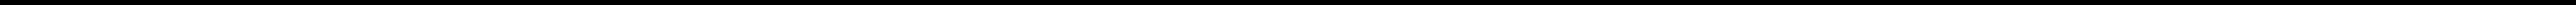

In [3]:
images_arrays = []
for f in images:
    np_image = np.array(Image.open(f).convert('RGB'))
    images_arrays.append(np_image)
    print(f, np_image.shape)

images_arr = np.hstack(images_arrays)
display(Image.fromarray(images_arr))

In [83]:
image_set = []
stride = 4
for image in [images_arrays[0], images_arrays[5], images_arrays[25]]:
    windowed_image = image[:, (np.arange((image.shape[1] - 240) // stride) * stride)[:, np.newaxis] + np.arange(240)].transpose(1, 0, 2, 3)
    image_set.append(windowed_image)
    print(windowed_image.shape)

(836, 208, 240, 3)
(708, 208, 240, 3)
(708, 208, 240, 3)


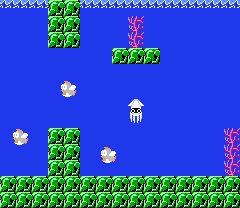

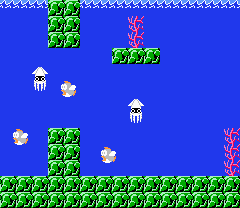

In [91]:
image_set_array = np.vstack(image_set)
display(Image.fromarray(image_set_array[836 + 300]))
display(Image.fromarray(image_set_array[836 + 708 + 300]))
# Image.fromarray(image_set_array[64]).save("example_slice.png")
Image.fromarray(image_set_array[836 + 300]).save("2-2_slice.png")
Image.fromarray(image_set_array[836 + 708 + 300]).save("7-2_slice.png")
# target_set_array = np.vstack(target_set).squeeze()
# print(image_set_array.shape)
# print(target_set_array.shape)

In [6]:
#images_arr.reshape(-1, 3).shape

In [7]:
#uniques = np.unique(images_arr.reshape(-1, 3), axis=0)
#print(uniques)

In [8]:
#np.save('palette', uniques)

In [9]:
palette = np.load('palette.npy')
palette = dict(enumerate(palette))
palette = dict((v.tobytes(),k) for k,v in palette.items())

In [10]:
images_byte_arrays = [np.apply_along_axis(lambda t : t.tobytes(), 2, image) for image in images_arrays]

In [11]:
image_byte_set = []
stride = 4
for image in images_byte_arrays:
    windowed_image = image[:, (np.arange((image.shape[1] - 240) // stride) * stride)[:, np.newaxis] + np.arange(240)].transpose(1, 0, 2)
    image_byte_set.append(windowed_image)
    print(windowed_image.shape)
target_set = [np.full((image_byte_set[i].shape[0], 1), i) for i in range(len(image_byte_set))]

(836, 208, 240)
(708, 208, 240)
(644, 208, 240)
(580, 208, 240)
(836, 208, 240)
(708, 208, 240)
(900, 208, 240)
(580, 208, 240)
(836, 208, 240)
(836, 208, 240)
(644, 208, 240)
(580, 208, 240)
(900, 208, 240)
(836, 208, 240)
(580, 208, 240)
(708, 208, 240)
(836, 208, 240)
(836, 208, 240)
(644, 208, 240)
(580, 208, 240)
(772, 208, 240)
(900, 208, 240)
(708, 208, 240)
(580, 208, 240)
(772, 208, 240)
(708, 208, 240)
(900, 208, 240)
(836, 208, 240)
(1540, 208, 240)
(900, 208, 240)
(900, 208, 240)
(1220, 208, 240)


In [12]:
image_byte_set_array = np.vstack(image_byte_set)
target_set_array = np.vstack(target_set).squeeze()
print(image_byte_set_array.shape)
print(target_set_array.shape)

(25344, 208, 240)
(25344,)


In [13]:
for key in palette:
    print(key, palette[key])
    image_byte_set_array[image_byte_set_array == key] = palette[key]
    
palletized_images = image_byte_set_array

b'\x00\x00\x00' 0
b'\x00@D' 1
b'\x00D\x00' 2
b'\x00T\x00' 3
b'\x00\x80\x88' 4
b'\x00\xa8\x00' 5
b'\x18<\\' 6
b' 8\xec' 7
b'.J~' 8
b'.\x9e~' 9
b':::' 10
b'<\xbc\xfc' 11
b'Eo\xbd' 12
b'\\\x94\xfc' 13
b'^^^' 14
b'd&\x06' 15
b'ttt' 16
b'w\x82\xc0' 17
b'~L\x1c' 18
b'~~~' 19
b'\x80\x80\x80' 20
b'\x80\xd0\x10' 21
b'\x84\x95\xcb' 22
b'\x88p\x00' 23
b'\x92p\x84' 24
b'\x9c\xfc\xf0' 25
b'\xa8\xf0\xbc' 26
b'\xac\x96\x9a' 27
b'\xac\xc8\xfc' 28
b'\xbc\xbc\xbc' 29
b'\xc8L\x0c' 30
b'\xd8(\x00' 31
b'\xe4\x00X' 32
b'\xfct\xb4' 33
b'\xfc\x988' 34
b'\xfc\xbc\xb0' 35
b'\xfc\xd8\xa8' 36
b'\xfc\xfc\xfc' 37


In [14]:
dirty_palette = [np.unique(level, return_counts=True) for level in palletized_images]
dirty_palette_indices = [a[0].astype(int) for a in dirty_palette]
dirty_palette_count = [a[1] for a in dirty_palette]

In [15]:
clean_palette_count = np.zeros((len(image_byte_set_array), len(palette)))
for i in range(clean_palette_count.shape[0]):
    clean_palette_count[i, dirty_palette_indices[i]] = dirty_palette_count[i]

In [16]:
print(clean_palette_count.astype(int))
print(clean_palette_count.shape)

[[ 1876     0     0 ...  1463     0   379]
 [ 1877     0     0 ...  1463     0   379]
 [ 1882     0     0 ...  1463     0   379]
 ...
 [38386     0     0 ...     0   137  4154]
 [38386     0     0 ...     0   137  4154]
 [38386     0     0 ...     0   137  4154]]
(25344, 38)


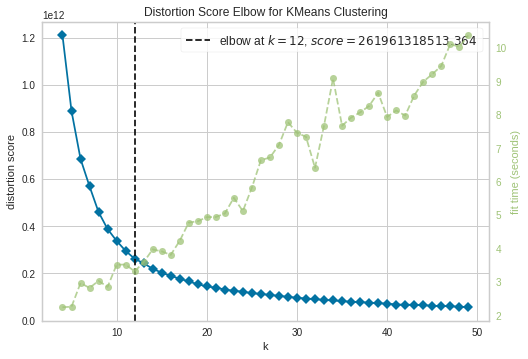

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
visualizer = KElbowVisualizer(KMeans(), k=(4,50))
visualizer.fit(clean_palette_count)
visualizer.show()

In [73]:
clusters = 12
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(clean_palette_count)
print(kmeans.labels_)
print(kmeans.score(clean_palette_count))

[1 1 1 ... 0 0 0]
-261963402527.12875


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

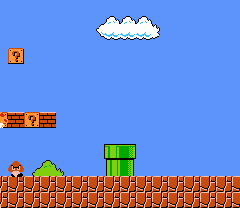

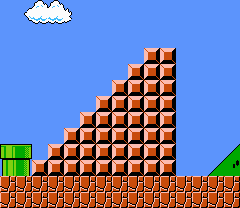

In [82]:
unique_kmeans_labels = np.unique(kmeans.labels_)

all_labels = kmeans.predict(clean_palette_count[0:836])
print(all_labels)
display(Image.fromarray(image_set_array[86]))
display(Image.fromarray(image_set_array[-5 * 24]))
Image.fromarray(image_set_array[86]).save("1-1_cluster_1.png")
Image.fromarray(image_set_array[-5 * 24]).save("1-1_cluster_10.png")

['1-1', '1-2', '1-3', '1-4', '2-1', '2-2', '2-3', '2-4', '3-1', '3-2', '3-3', '3-4', '4-1', '4-2', '4-3', '4-4', '5-1', '5-2', '5-3', '5-4', '6-1', '6-2', '6-3', '6-4', '7-1', '7-2', '7-3', '7-4', '8-1', '8-2', '8-3', '8-4']


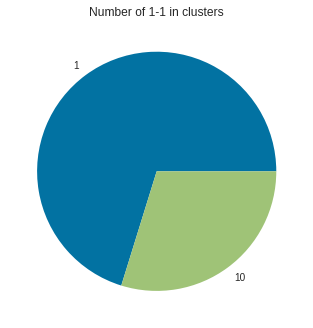

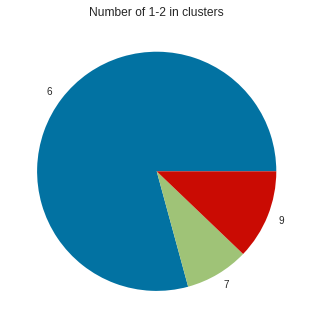

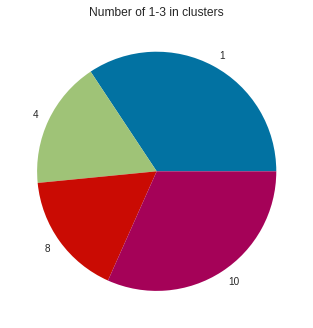

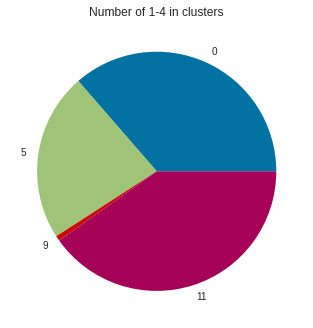

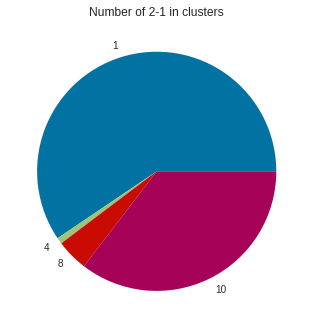

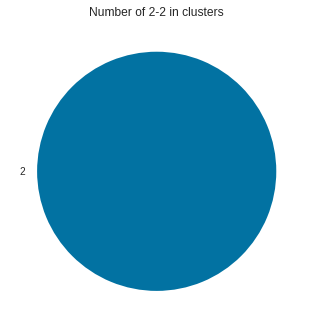

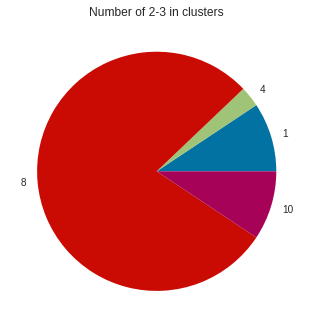

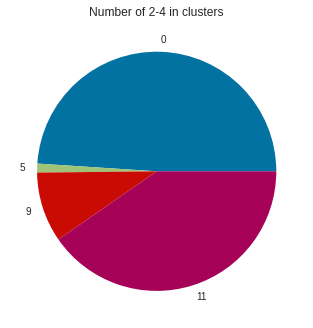

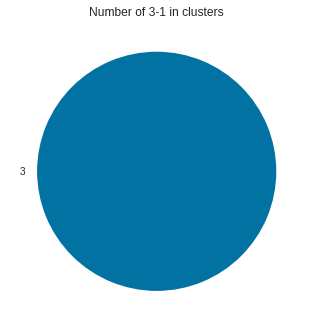

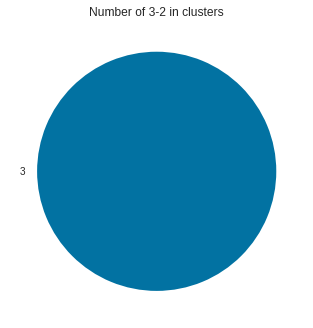

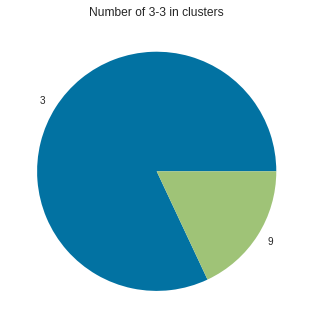

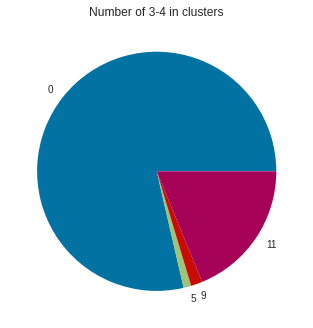

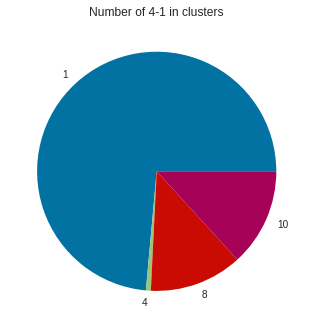

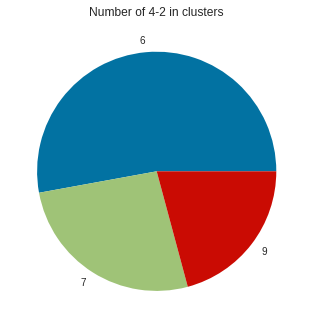

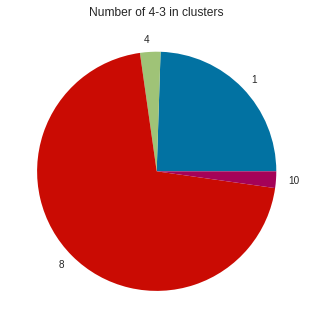

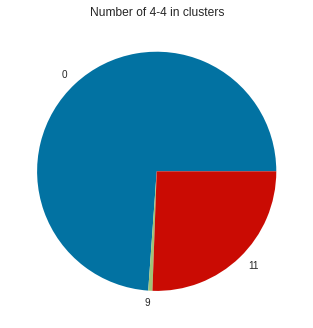

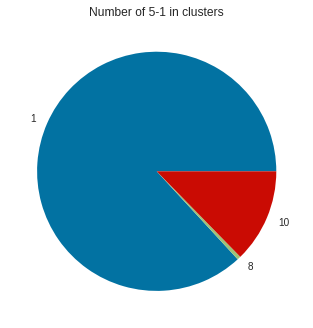

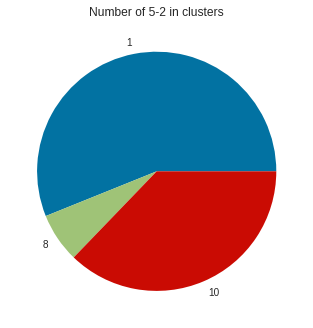

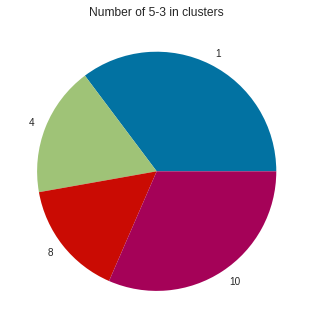

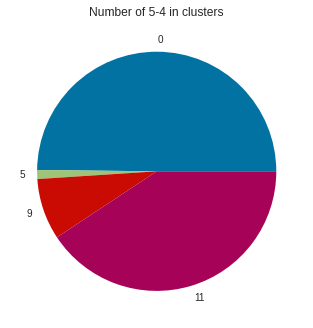

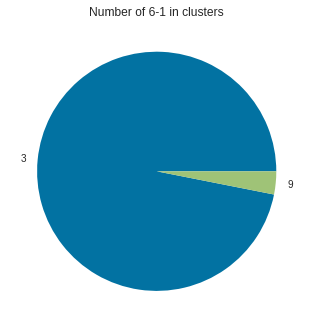

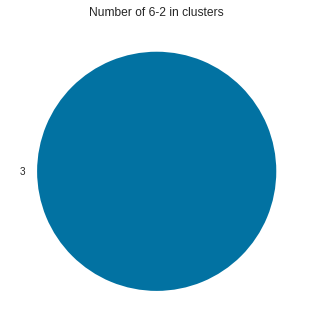

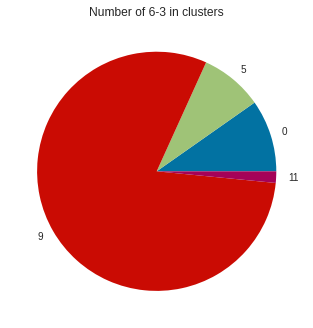

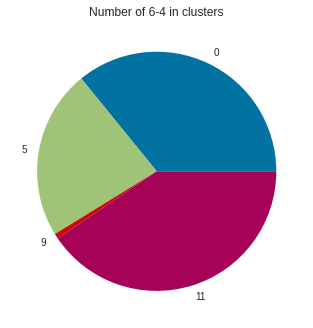

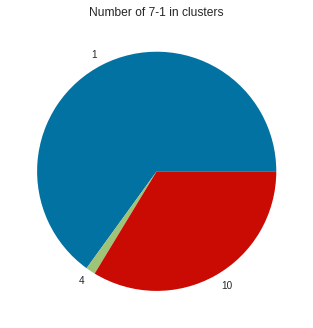

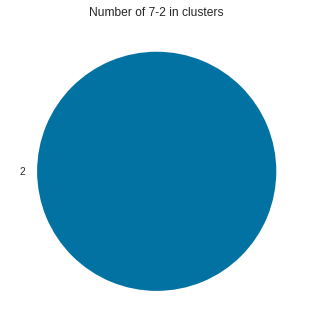

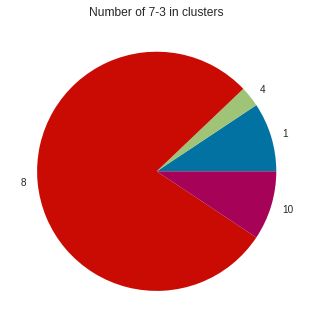

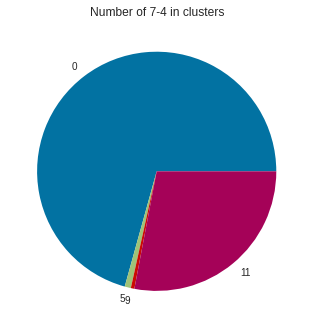

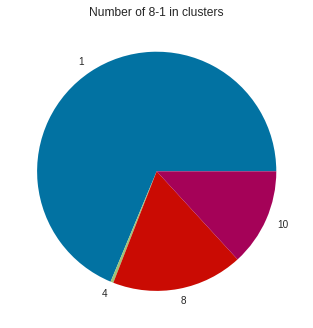

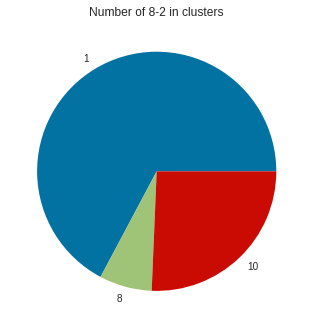

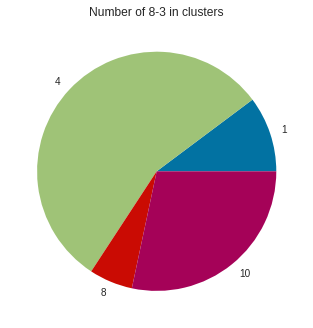

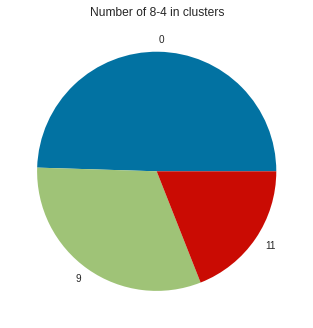

In [75]:
level_labels = [f"{i}-{j}" for i in range(1, 9) for j in range(1, 5)]
print(level_labels)

#fig, ax = plt.subplots()
for i in range(len(level_labels)):
    dirty_level_label_indices, dirty_level_label_count = np.unique(kmeans.labels_[np.argwhere(target_set_array == i)], return_counts=True)
    clean_level_label_count = np.zeros(len(unique_kmeans_labels))
    clean_level_label_count[dirty_level_label_indices] = dirty_level_label_count
    plt.pie(dirty_level_label_count, labels=dirty_level_label_indices)
#     plt.bar(unique_kmeans_labels, clean_level_label_count, 1, label=level_labels[i])
#     plt.xlabel('Cluster ID')
#     plt.ylabel('Number in cluster')
    plt.title(f"Number of {level_labels[i]} in clusters")
    plt.show()

# ax.set_xlabel('Cluster ID')
# ax.set_ylabel('Number in cluster')
# ax.set_title('Number in cluster by level and cluster')
# ax.legend()
# plt.show()